In [1]:
import torch

In [2]:
import os
from PIL import Image
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2
import numpy as np


def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',))


In [3]:
img_path = 'RowanDLclassNEA/NEUdata/Cr/Cr_10.bmp'
np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
np_img = cv2.imread(img_path)

#### We need to write a transform to make it compatible with AlexNet (size 224x224x3, and type tensor)

In [4]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

dset = DatasetFolder(root='RowanDLclassNEA/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)

### Note that load_image  needed to return a PIL.Image for the transforms to be correctly applied


In [5]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)



 ### We are going to illustrate transfer learning now
Transfer starts with a pretrained model from the torchvision library. The pretrained model will be resnet18. This model is trained on ImageNet 1K (this is the default for resnet18: DEFAULT = IMAGENET1K_V1)
The fact that ImageNet consists of RGB images of size 224 x 224 demanded our data resizing in the transform

In [6]:
import torchvision.models as models
import torch.nn as nn
from torchinfo import summary

orig_model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)
summary(orig_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### notice that the last layer of the resnet18 is a linear layer with output size 1000
Let's get rid of it, because we have only 6 classes!

Plus, add the FlattenLayer to see what is the linearized size of the last AvgPool

In [7]:
layers = list(orig_model.children())[:-1]  #get all the layers except the last one
layers.append(nn.Flatten())   
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 512]                 --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

In [8]:
layers.append(nn.Linear(512,6))
vec_model = nn.Sequential(*layers)
summary(vec_model, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 6]                   --
+ Conv2d: 1-1                            [16, 64, 112, 112]        9,408
+ BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
+ ReLU: 1-3                              [16, 64, 112, 112]        --
+ MaxPool2d: 1-4                         [16, 64, 56, 56]          --
+ Sequential: 1-5                        [16, 64, 56, 56]          --
|    + BasicBlock: 2-1                   [16, 64, 56, 56]          --
|    |    + Conv2d: 3-1                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-2             [16, 64, 56, 56]          128
|    |    + ReLU: 3-3                    [16, 64, 56, 56]          --
|    |    + Conv2d: 3-4                  [16, 64, 56, 56]          36,864
|    |    + BatchNorm2d: 3-5             [16, 64, 56, 56]          128
|    |    + ReLU: 3-6                    [16, 64, 56, 56]          --
|

### Alternatively, just replace model.fc with the linear layer

In [9]:
import copy
alt_model = copy.deepcopy(orig_model)
alt_model.fc = nn.Linear(512,6)

In [10]:
from torch import optim
from torch import nn
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vec_model.to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
 
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=10)


N_EPOCHS = 20
tr_loss_hist = []
val_loss_hist = []
for epoch in range(N_EPOCHS):

    # Training 
    train_loss = 0.0
    model.train() # <1>
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    model.eval() # <2>
    for inputs, labels in valloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_loss += loss.item()

    print("Epoch: {} Train Loss: {} Val Loss: {}".format(
                  epoch, 
                  train_loss/len(trainloader), 
                  val_loss/len(valloader)))
    tr_loss_hist.append(train_loss/len(trainloader))
    val_loss_hist.append(val_loss/len(valloader))

Epoch: 0 Train Loss: 0.9289578592777252 Val Loss: 0.29741382108707176
Epoch: 1 Train Loss: 0.28595682044823967 Val Loss: 0.11196782949723695
Epoch: 2 Train Loss: 0.14366750339667003 Val Loss: 0.07061921996309568
Epoch: 3 Train Loss: 0.11242915165921052 Val Loss: 0.048501502183315004
Epoch: 4 Train Loss: 0.08318958821396033 Val Loss: 0.03418672000254063
Epoch: 5 Train Loss: 0.06642591332395871 Val Loss: 0.03171875634181656
Epoch: 6 Train Loss: 0.0588155919375519 Val Loss: 0.02463707629297125
Epoch: 7 Train Loss: 0.041334652298440536 Val Loss: 0.019912642371644706
Epoch: 8 Train Loss: 0.05182842489952842 Val Loss: 0.017920625861734152
Epoch: 9 Train Loss: 0.03316622178380688 Val Loss: 0.015486056034110095
Epoch: 10 Train Loss: 0.04017882913351059 Val Loss: 0.019481251469666238
Epoch: 11 Train Loss: 0.02594073295593262 Val Loss: 0.01718489785592905
Epoch: 12 Train Loss: 0.040053642715017 Val Loss: 0.019486153651470023
Epoch: 13 Train Loss: 0.03226032951846719 Val Loss: 0.01488532272694436

Text(0.5, 1.0, 'Loss Curves')

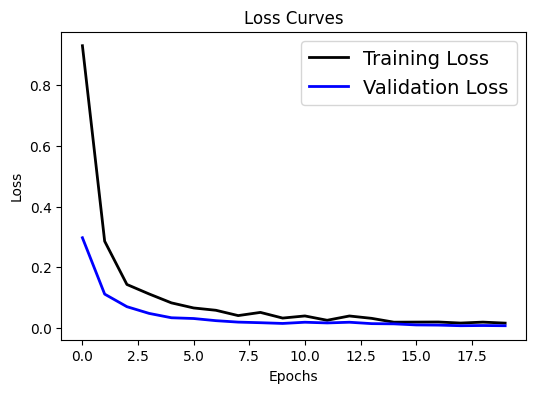

In [11]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(tr_loss_hist, 'black', linewidth=2.0)
plt.plot(val_loss_hist, 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)